![NVIDIA Logo](images/nvidia.png)

# Apply LoRA to the List Generation Task

Now that you've prepared prompt and label data for list generation, it's time to do parameter efficient fine-tuning on a GPT8B model for list generation.

---

## Learning Objectives

By the time you complete this notebook you will:
- LoRA fine-tune a GPT8B model for list generation.
- Evaluate the fine-tuned models performance and articulate its limitations.
- Create a list generation LLM function for easy reuse of the custom model's intented functionality.

---

## Imports

In [1]:
import json
import ast

from tqdm.notebook import tqdm

from llm_utils.nemo_service_models import NemoServiceBaseModel
from llm_utils.models import LoraModels
from llm_utils.mocks import create_list_gen_lora_customization as create_customization
from llm_utils.helpers import plot_experiment_results
from llm_utils.prompt_templates import gen_list_template_zero_shot
from llm_utils.llm_functions import make_llm_function
from llm_utils.postprocessors import postprocess_list

---

## List Models

In [2]:
LoraModels.list_models()

gpt8b: gpt-8b-000-lora
gpt43b: gpt-43b-002-lora


---

## Training and Validation Data

In the last notebook you generated 100 prompt/response training samples for list generation. Using the same process we generated about 900 samples, and split them into train, validation, and test data. In the case of the train and validation data we also formatted the data appropriately for NeMo Service customization and uploaded them to the NeMo Service.

In [3]:
!ls data/list_gen*

data/list_gen_test_25.json     data/list_gen_val_88.jsonl
data/list_gen_train_797.jsonl


---

## Dataset File IDs

After uploading the training and validation data, we obtained the following file IDs, which you will need to use below.

In [4]:
training_dataset_file_id = '85218a48-86a5-46d8-94cf-96a24f3078fa'
validation_dataset_file_id = '419c55e3-2fbc-41cb-9bed-c0482f3ba26d'

---

## Exercise: LoRA Fine-tune GPT8B for List Generation

![List Gen LoRA](images/list_gen_lora.png)

Your task is to launch a LoRA customization job for list generation using the appropriate GPT8B model. Instead of establishing an actual connection to NeMo Service with `conn.create_customization`, you will use our mock `create_customization` function imported above. If you don't pass in the correct arguments, the function will tell you. When you do successfully provide the correct arguments for the LoRA customization, the function will provide you with a customization ID for a LoRA customization we have already completed, that you will us later in this notebook.

We ran our training for 50 epochs, but the training exited after 13 epochs, having gone for 10 epochs without any improvement to the validation loss. The best epoch was 3 and the checkpoints for this epoch are what are used in the customization. Therefore, for this customization, train for 3 epochs.

For your reference, here is the solution from the previous PubMedQA LoRA customization job you performed earlier:

```python
create_customization(model='gpt-8b-000-lora',
                     training_dataset_file_id='cb1aab08-e396-41a8-9334-571c6672033d',
                     validation_dataset_file_id='42d75e3a-7aa9-46fa-b1c0-63d7a66f7a8f',
                     adapter_dim=32,
                     epochs=3)
 ```

If you get stuck, feel free to check out the solution below.

Correctly launch a (mock) LoRA customization using `create_customization` immediately below. On success, when you ascertain the customization ID, set the `customization_id` variable below to it for use later in the notebook.

If you get stuck, feel free to check out our *Solution* below.

In [5]:
create_customization(model='gpt-8b-000-lora',
                     training_dataset_file_id=training_dataset_file_id,
                     validation_dataset_file_id=validation_dataset_file_id,
                     adapter_dim=32,
                     epochs=3)

'LoRA customization job for GPT8B succesfully launched! Customization ID: 03f25d3b-715d-44cb-b682-61ef6f7df476'

In [6]:
customization_id = '03f25d3b-715d-44cb-b682-61ef6f7df476'

---

## Evaluate Fine-tuned Model Performance

Now you're ready to evaluate the performance of our LoRA fine-tuned GPT8B model on list generation.

---

## LoRA Customization Model Instance

Run the cell below to instantiate an instance of the LoRA fine-tuned GPT8B model.

In [7]:
model = NemoServiceBaseModel(model=LoraModels.gpt8b.value, customization_id=customization_id)

---

## Load Test Data

As mentioned earler, we've created test data for your use.

In [8]:
prompts_and_labels = json.load(open('data/list_gen_test_25.json','r'))

In [9]:
len(prompts_and_labels)

25

In [10]:
for prompt, label in prompts_and_labels[:3]:
    print(prompt)
    print(label)
    print()

Make a python list of 3 fruits.
['apple', 'banana', 'orange']

Make a python list of 5 colors.
['red', 'green', 'yellow', 'blue', 'purple']

Make a python list of 7 shapes.
['square', 'circle', 'triangle', 'pentagon', 'hexagon', 'heptagon', 'rectangle']



---

## Try LoRA Fine-tuned Model

In [11]:
for prompt, label in prompts_and_labels[:4]:
    response = model.generate(prompt, return_type='text', stop=['\n']).strip()
    print(prompt)
    print(response+'\n')

Make a python list of 3 fruits.
['banana', 'apple', 'orange']

Make a python list of 5 colors.
['red', 'green', 'blue', 'yellow', 'orange']

Make a python list of 7 shapes.
['square', 'circle', 'triangle', 'pentagon', 'hexagon', 'octagon', 'rhombus']

Make a python list of 7 numbers.
[7, 6, 3, 2, 1, 4, 5]



So far this looks pretty good.

---

## Testing Generated List

We need to consider how we are going to evaluate the perfomance of our custom model given that we have no guarantees about the actual list items it is going to produce. For example, for the prompt "Make a python list of 2 colors." both `['green', 'blue']` and `['silver', 'gold']` would be appropriate responses.

In other scenarios we might very well wish to go through the effort of providing a way to evaluate that the items are appropriate to the `topic` that was passed into `generate_list`, perhaps using an LLM to help us. However, for the sake of time, and also because in all our experiments with list generation thus far we haven't seen much, if anything, in the way of off-topic responses, let's just agree that we need to test that we have a well-formed list, and that it needs to be of the appropriate length.

To that end we will use the following function that will convert our model's generated list, confirm it is a well-formed list, remove any duplicate entries and return the list's length. If the model response is not a well-formed list, we will return `-1`.

In [12]:
def get_good_gen_list_len(response: str) -> str:
    try:
        literal_list = ast.literal_eval(response.strip())
    except:
        return -1

    try:
        num_unique_items = len(set(literal_list))
    except:
        return -1
    return num_unique_items

In [13]:
good_list = "['a', 'b', 'c']"
bad_list_with_duplicates = "['a', 'b', 'a']"
bad_list_formed_wrong = "['a', 'b', 'c']]"

lists = [good_list, bad_list_with_duplicates, bad_list_formed_wrong]

In [14]:
for l in lists:
    print(get_good_gen_list_len(l))

3
2
-1


In this approach, our labels should be the target length. Let's assume with the above toy lists we intended for them all to have a length of 3.

In [15]:
for l in lists:
    test_result = get_good_gen_list_len(l) == 3
    print(f'List {l} is correct: {test_result}')

List ['a', 'b', 'c'] is correct: True
List ['a', 'b', 'a'] is correct: False
List ['a', 'b', 'c']] is correct: False


---

## Try LoRA Fine-tuned Model on Full Test Dataset

Let's run through the test data using the technique we described just above. In the case that we get an incorrect response, we will print the prompt and response so we can investigate.

In [16]:
for prompt, label in tqdm(prompts_and_labels):
    response = model.generate(prompt, return_type='text', stop=['\n']).strip()
    response_len = get_good_gen_list_len(response)
    is_correct = response_len == len(label)
    if not is_correct:
        print(prompt)
        print(response+'\n')

  0%|          | 0/25 [00:00<?, ?it/s]

Make a python list of 8 kinds of clothes.
['pants', 'sweater', 'shirt', 'sweatpants', 'shorts', 'sweater', 'sweatpants', 'shirt']

Make a python list of 1 books.
['The Hitchhiker's Guide to the Galaxy']

Make a python list of 8 movies.
['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions', 'The Animatrix', 'The Matrix Resurrections', 'The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']

Make a python list of 8 games.
['go', 'chess', 'checkers', 'backgammon', 'mahjong', 'poker', 'slots', 'slots']

Make a python list of 9 birds.
['penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin', 'penguin']

Make a python list of 8 reptiles.
['snake', 'iguana', 'chameleon', 'tortoise', 'iguana', 'crocodile', 'tortoise', 'snake']



---

## Analysis

For the most part it looks like our model had difficulty not introducing duplicates when the target length was 8 or 9. We could try to address this in the following ways:

- Only use this model to generate lists of length 7 or less when possible duplication is an issue.
- Try to adjust `top_k` and `temperature` to see if introducing randomness results in a reduction of inputs.
- Iterate on our prompt template used in training:
    - Instead of "Make a python list of {n} {topic}" try "Make a python list of {n} {topic} without any duplicates."
 
There was also one response, `['The Hitchhiker's Guide to the Galaxy']`, where the item in the list contained an apostrophe `'` that caused the list to be malformed. We might consider post-processing to handle this kind of output.

Of course, we also might be perfectly satisfied with the list generator not always performing perfectly. A simple guard in our code like:

```python
response = generate_list(n, topic)
if not response:
    # Do something here in case we didn't get a well-formed response
```

...could be completely appropriate.

---

## Compare LoRA Fine-tuned Performance With Other Models

We conducted evaluation with the same small test data set on a variety of models for zero, one, two and three shot learning, in addition to LoRA fine-tuned where possible. As we discussed in this notebook, we converted our generated list labels to their length and used `get_good_gen_list_len` to parse the output of our models' responses to compare to the length of the label.

For your reference, for each model tested we did:

```python
model.evaluate(prompts_and_label_lengths,
                get_clean_prediction=get_good_gen_list_len,
                stop=['\n'])
```

The results follow.

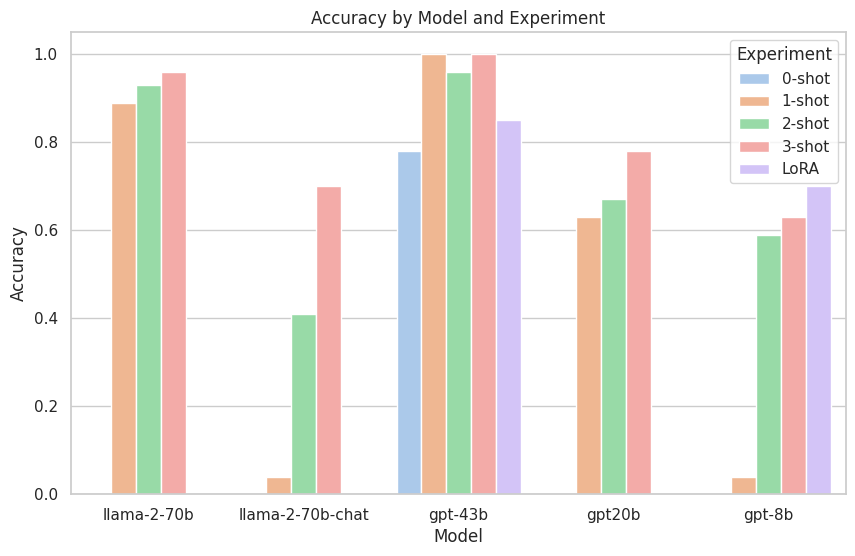

In [17]:
plot_experiment_results('experiment_results/solutions/list_gen_experiment_results.csv')

---

## Analysis

LLaMA-2-70B and especially GPT43B performed the best at list generation, especially GPT43B which with few-shot learning was able to acheive perfect accuracy on our test set. Interestingly, and for reasons that would require additional investigation to understand, GPT43B LoRA did not perform as well as few-shot learning. Assuming accuracy, and especially with larger list lengths, were a priority at any cost, One-shot GPT43B would appear to be a reasonable choice.

GPT8B improved its performance the more shots we gave it, but performed the best with LoRA with 76% accuracy. As discussed earlier in the notebook, GPT8B with LoRA did poorly with lists of length 8 and larger, producing well-formed outputs, but with repeat entries. Depending on the application, this may or may not be an issue and also, could be worked around by keeping list lengths to 7 or less. Assuming we would be willing to work with this constraint in some fashion, using GPT8B with LoRA gives us a fast response while using very few tokens and with a relatively small model.

GPT20B performed slightly better than 8B. For this list generation task given that it is 2x GPT8B with LoRA and performed only slightly better, we would likely not choose it.

LLaMA-2-70B-chat did a surprisingly poor job on this task, largely because of its tendency to be so "helpful" and provide extra conversational text. However, we note that with each shot its performance increased drastically, therefore, if for other reasons we wanted to work with this model, we might consider 4 or 5 shot prompting it to see how that impacted its performance.

---

## Exercise: Create LLM Function

![List Gen](images/list_gen.png)

Now that we have a customized model and are satisfied with how it is working, let's take the time to create an LLM function that encapsulates the list generation task.

As a reminder, we use `make_llm_function` to return an LLM function. `make_llm_function` expects the following arguments:
1. A model instance: in this case use your LoRA-customized GPT8B model.
2. A prompt template: in this case use `gen_list_template_zero_shot` provided below.
3. An optional postprocessor: in this case use `postprocess_list` provided below, which will deduplicate your list and return an empty list in the case of model responses that are not well formed.

### List Generation Prompt Template

It's worth noting that in our prompt engineered list generator we did few-shot learning, but with our fine-tuned model this is no longer required. Thus the following prompt template, intended for zero-shot prompts, will look different than our earlier few-shot prompt template.

In [18]:
def gen_list_template_zero_shot(n, topic):
    return f'Make a python list of {n} {topic}.'

### List Postprocessor

The following, which you have seen before, will return an empty list in cases where the model's response is not a well-formed list, and will also de-duplicate any lists generated by the model.

In [19]:
def postprocess_list(list_str):
    try:
        literal_list = ast.literal_eval(list_str)
    except:
        literal_list = []

    return list(set(literal_list))

In [23]:
generate_list = make_llm_function(
    NemoServiceBaseModel(LoraModels.gpt8b.value, customization_id='03f25d3b-715d-44cb-b682-61ef6f7df476'), 
    gen_list_template_zero_shot, 
    postprocessor=postprocess_list)

Once you have implemented `generate_list` you should be able to run the following cell without any issues, and see your function generating well-formed lists.

In [24]:
ns = [3, 4, 5, 6]
topics = ['first names', 'cities in Maryland', 'bike products', 'moods']
for n, topic in zip(ns, topics):
    response = generate_list(n, topic)
    print(f'Make a python list of {n} {topic}.')
    print(response)

Make a python list of 3 first names.
['Joe', 'Jane', 'John']
Make a python list of 4 cities in Maryland.
['Washington', 'Annapolis', 'Baltimore', 'Maryland']
Make a python list of 5 bike products.
['bike', 'helmet', 'seat', 'lock', 'pump']
Make a python list of 6 moods.
['bored', 'angry', 'scared', 'happy', 'confused', 'sad']


In [25]:
ns = [3, 4, 5, 6]
topics = ['first names', 'cities in California', 'bike products', 'moods']
for n, topic in zip(ns, topics):
    response = generate_list(n, topic)
    print(f'Make a python list of {n} {topic}.')
    print(response)

Make a python list of 3 first names.
['Joe', 'Jane', 'John']
Make a python list of 4 cities in California.
['Los Angeles', 'San Diego', 'San Jose', 'San Francisco']
Make a python list of 5 bike products.
['bike', 'helmet', 'seat', 'lock', 'pump']
Make a python list of 6 moods.
['bored', 'angry', 'scared', 'happy', 'confused', 'sad']
